# Generative Adversarial Networks (GAN)

In this notebook, we will go through basics of GAN and implement wgan on different dataset other than MNIST. We will use pokemon dataset.

**Issue**: *Model keeps breaking ... for both wgan ... Mode collapse* 

Here we will use [fastai](https://docs.fast.ai/  "Fastai Documentation").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/gan/2019/04/13/Power-of-GAN/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/GAN/gan_fastai.ipynb)


### Get Data

In [0]:
import os
from pathlib import Path
os.mkdir('data')
os.mkdir('images')

path = Path('data')

In [0]:
from google.colab import files
files.upload()

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d dollarakshay/pokemon-images -p {path}

In [0]:
!unzip {path}/'pokemon-images.zip' -d {path}

In [0]:
!unzip {path}/'POKEMON.zip' -d {path}

In [0]:
!ls -lR /content/data/POKEMON/*.png | wc -l #number of train images

## EDA

In [0]:
from pathlib import Path
path = Path('data/POKEMON')

In [0]:
import matplotlib.pyplot as plt
import random
import os
import imageio
%matplotlib inline

def show_images(img_path, path, rows=2, columns=4):
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(path/img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(f'Image size: {img.shape}')
        plt.axis('off')

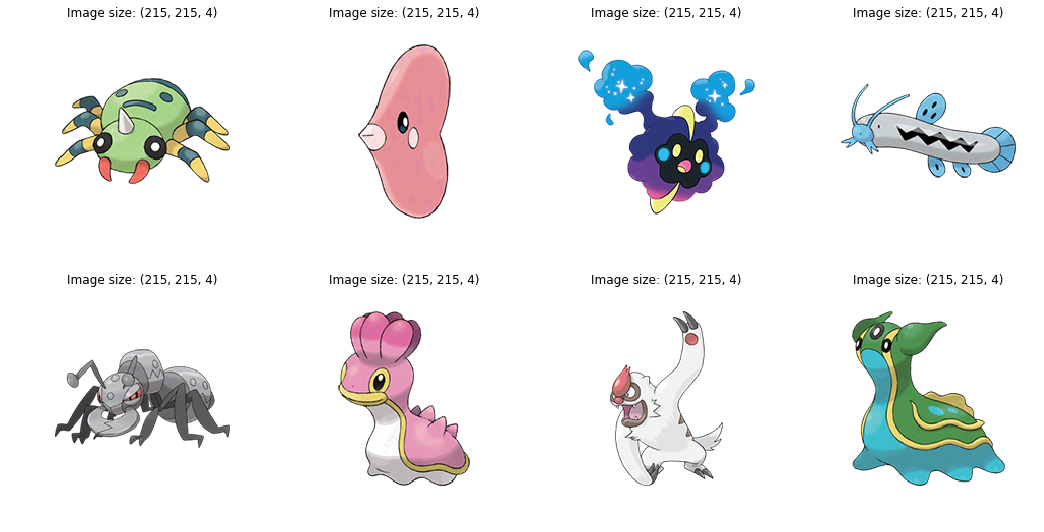

In [0]:
# no, I don't know their names :(
rnd_images = random.sample(os.listdir(f'{path}'), 8)
show_images(rnd_images, path)

# Fastai

Code Credits: [fastai](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-wgan.ipynb)

In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *

from pathlib import Path
path = Path('data/POKEMON')

## WGAN


We train them against each other in the sense that at each step (more or less), we:

    Freeze the generator and train the critic for one step by:
        getting one batch of true images (let's call that real)
        generating one batch of fake images (let's call that fake)
        have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
        update the weights of the critic with the gradients of this loss

    Freeze the critic and train the generator for one step by:
        generating one batch of fake images
        evaluate the critic on it
        return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
        update the weights of the generator with the gradients of this loss


In [0]:
bs = 32
size = 256

In [0]:
data = (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats =[torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

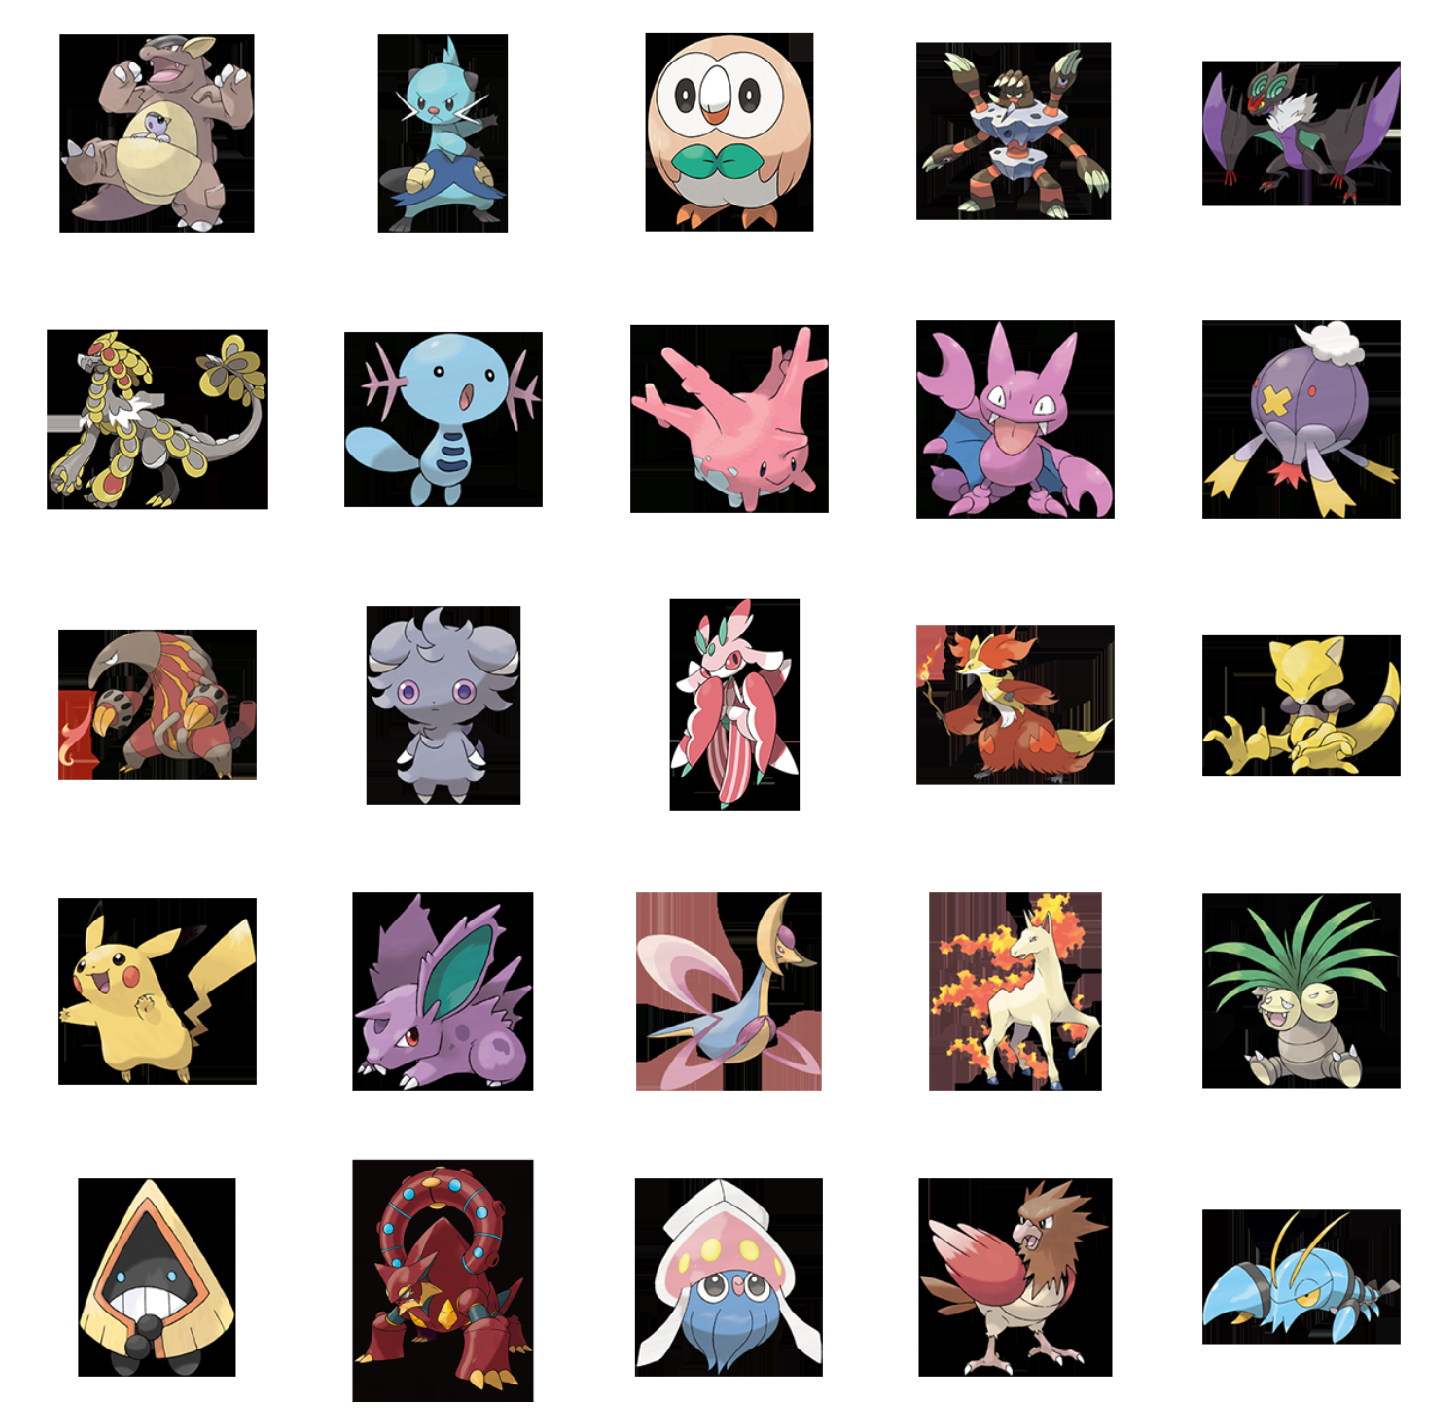

In [0]:
data.show_batch()

In [0]:
generator = basic_generator(in_size=size, n_channels=3, n_extra_layers=5)
critic = basic_critic(in_size=size, n_channels=3, n_extra_layers=5)

In [0]:
generator

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_s

In [0]:
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel

In [0]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

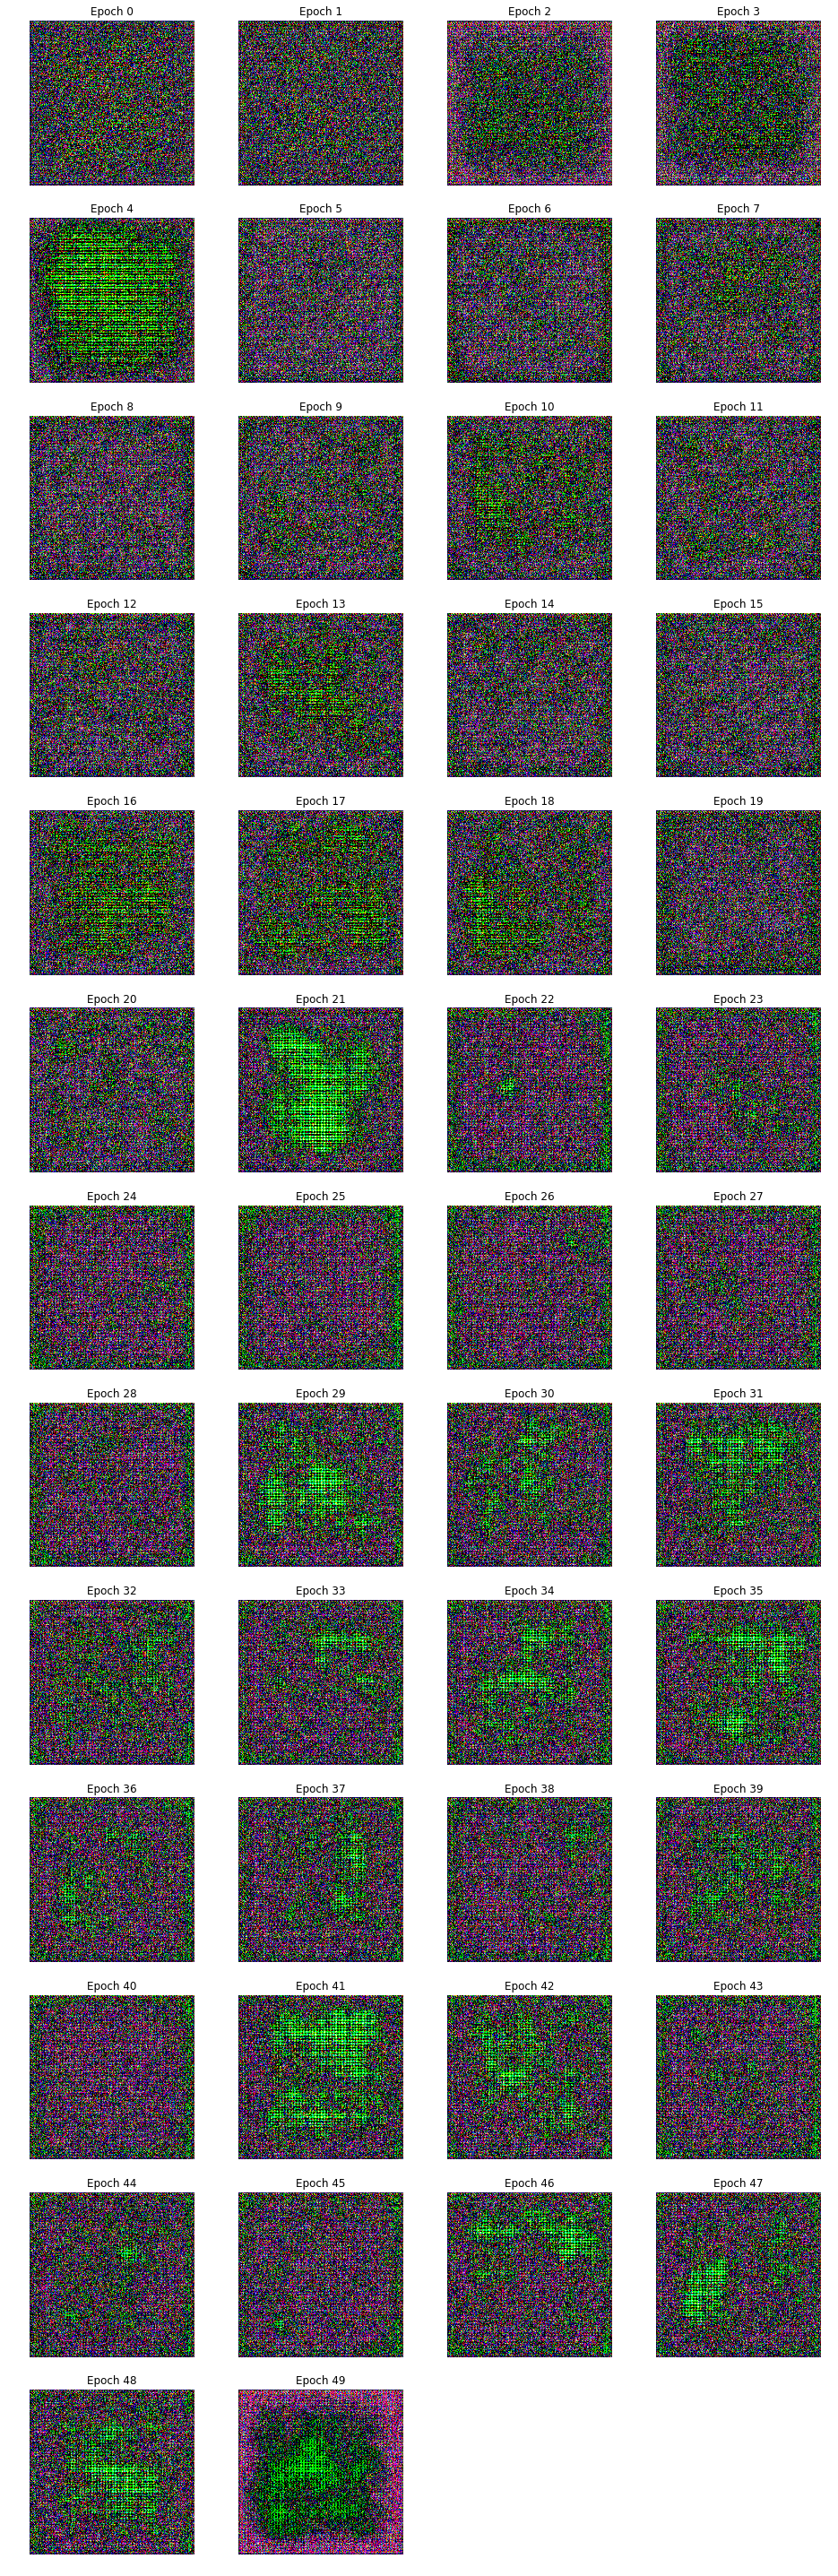

In [0]:
learn.fit(50, 2e-4)

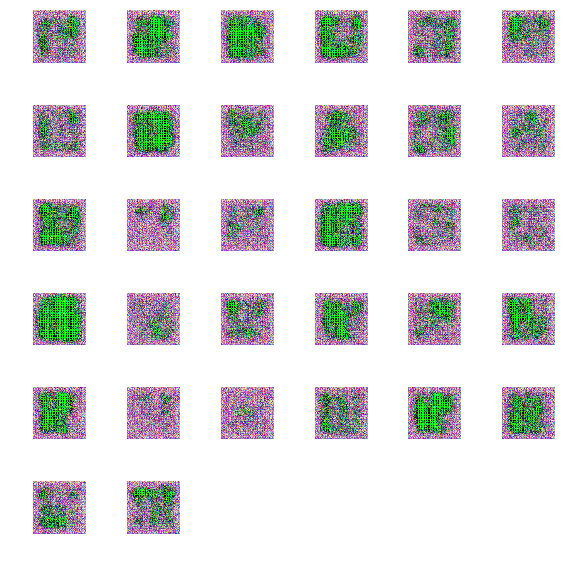

In [0]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))